# Neural Networks

In [1]:
import librosa
import librosa.core.spectrum
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

In [2]:
# read file (stereo)
original, fs = librosa.core.load("../data/trance.wav", sr=44100, mono=False)

In [3]:
# process
spectrogram = [librosa.core.stft(original[0], n_fft=1024), librosa.core.stft(original[1], n_fft=1024)]
abs_spectrogram = np.abs(spectrogram)

In [4]:
# quantisation
quantised_spectrogram = (10 * np.sqrt(abs_spectrogram, out=np.zeros_like(abs_spectrogram), where=(abs_spectrogram != 0))).round().astype(np.int16)

In [5]:
# Cut frequency spectrum and start from audio beginning
window = quantised_spectrogram[0, :100, 150:500]/np.max(quantised_spectrogram[0, :100, 150:500])

## RNN

In [6]:
import numpy as np
from numpy.random import randn

class RNN:
  # A many-to-one Vanilla Recurrent Neural Network.

  def __init__(self, input_size, output_size, hidden_size):
    # Weights
    self.Whh = randn(hidden_size, hidden_size) * 0.01
    self.Wxh = randn(hidden_size, input_size) * 0.01
    self.Why = randn(output_size, hidden_size) * 0.01

    # Biases
    self.bh = np.zeros((hidden_size, 1))
    self.by = np.zeros((output_size, 1))

  def forward(self, inputs):
    '''
    Perform a forward pass of the RNN using the given inputs.
    Returns the final output and hidden state.
    - inputs is an array of vectors with shape (input_size, 1).
    '''
    h = np.zeros((self.Whh.shape[0], 1))

    self.last_inputs = inputs
    self.last_hs = { 0: h }
    y = np.zeros(inputs.shape) # array for predictions

    # Perform each step of the RNN
    for i, x in enumerate(inputs):
      h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
      self.last_hs[i + 1] = h
      # Compute the output
      y[i] = self.Why @ h + self.by

    return y, h

  def backprop(self, d_y, learn_rate=1e-1):
    '''
    Perform a backward pass of the RNN.
    - d_y (dL/dy) has shape (output_size, 1).
    - learn_rate is a float.
    '''
    n = len(self.last_inputs)

    # Calculate dL/dWhy and dL/dby.
    d_Why = d_y @ self.last_hs[n].T
    d_by = d_y

    # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
    d_Whh = np.zeros(self.Whh.shape)
    d_Wxh = np.zeros(self.Wxh.shape)
    d_bh = np.zeros(self.bh.shape)

    # Calculate dL/dh for the last h.
    # dL/dh = dL/dy * dy/dh
    d_h = self.Why.T @ d_y

    # Backpropagate through time.
    for t in reversed(range(n)):
      # An intermediate value: dL/dh * (1 - h^2)
      temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)

      # dL/db = dL/dh * (1 - h^2)
      d_bh += temp

      # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
      d_Whh += temp @ self.last_hs[t].T

      # dL/dWxh = dL/dh * (1 - h^2) * x
      d_Wxh += temp @ self.last_inputs[t].T

      # Next dL/dh = dL/dh * (1 - h^2) * Whh
      d_h = self.Whh @ temp

    # Clip to prevent exploding gradients.
    for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
      np.clip(d, -1, 1, out=d)

    # Update weights and biases using gradient descent.
    self.Whh -= learn_rate * d_Whh
    self.Wxh -= learn_rate * d_Wxh
    self.Why -= learn_rate * d_Why
    self.bh -= learn_rate * d_bh
    self.by -= learn_rate * d_by
    
    
def loss(y, y_true):
    return (y-y_true)
        
def loss_array(y, y_true):
    loss = np.zeros(y[0].shape)
    for yi, yi_true in zip(y, y_true):
        loss += yi - yi_true
    return loss

In [7]:
# Create RNN with in- and output sizes of 100 and 1000 as size of hidden layer
# The network is fed blocks of 100 frequency lines and 5 time slices
rnn = RNN(100, 100, 1000)
i = 0
t_width = 5

In [25]:
# Manual step (without learning)
# Run this and the next cell to continue learning. After ~10 iterations, the predictions become usable
x = np.expand_dims(window[:, i:i+t_width].T, -1) # at each time step, we need a (t_width, input_size, 1) matrix, not a vector
y_true = np.expand_dims(window[:, i+1:i+t_width+1].T, -1)
y, h = rnn.forward(x)
i += 1

In [26]:
# Compute error and backpropagate it
dy = loss(y[-1], y_true[-1]) # dL/dy
# dy = loss_array(y, y_true) # dL/dy
rnn.backprop(dy, learn_rate=0.1)

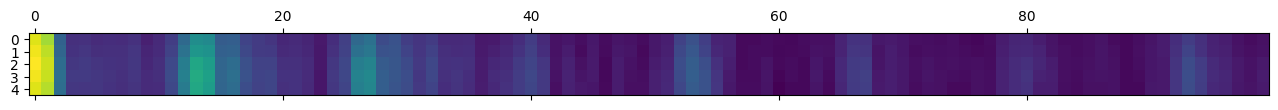

In [27]:
# Learned output
plt.matshow(y[:, :, 0])

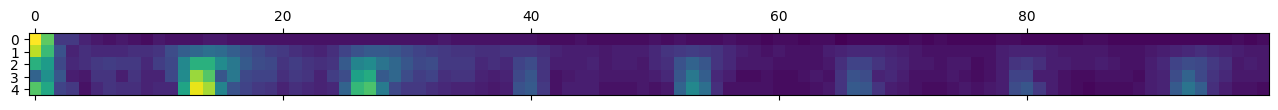

In [28]:
# True output
plt.matshow(y_true[:, :, 0])

## Reservoir Computing

In [29]:
# Code taken from https://github.com/cknd/pyESN
def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

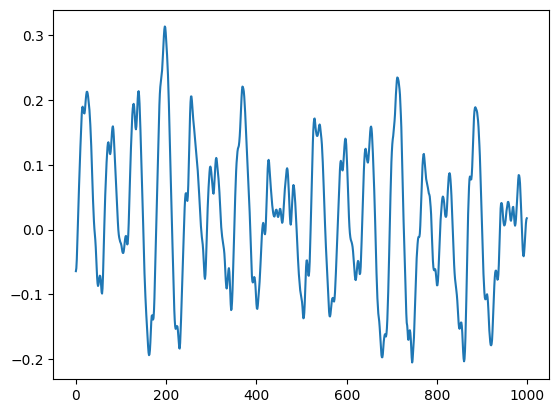

In [30]:
# Select smaller window from one channel
data = original[0,80000:]
# Visualise first 1000 waveform samples
plt.plot(data[:1000])

### With stimulation

In [31]:
# Invoke new ESN
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 200,
          spectral_radius = 0.4,
          sparsity = 0.1,
          noise = 0.0002,
          random_state=42)
# Predict 100 samples into the future based on 1000 previous samples
trainlen = 2000
testlen = 300

In [32]:
# Training data is shifted by one
pred_training = esn.fit(data[:trainlen-testlen], data[testlen:trainlen])
prediction = esn.predict(data[trainlen-testlen:trainlen])
print(f"Error: {(np.sqrt(np.mean(np.square(prediction - data[trainlen:trainlen+testlen]))))}")

Error: 0.09357377803461786


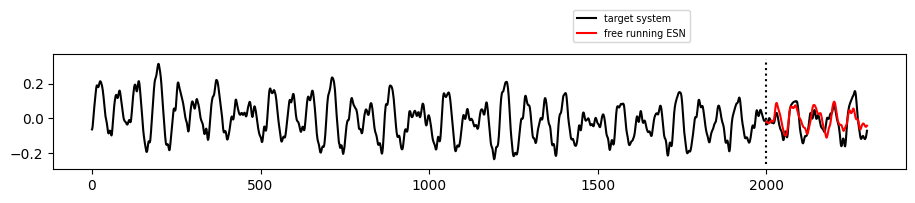

In [33]:
plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+testlen),data[0:trainlen+testlen],'k',label="target system")
plt.plot(range(trainlen,trainlen+testlen),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend(loc=(0.61,1.1),fontsize='x-small')

In [34]:
np.savetxt("esn1.txt", np.column_stack([range(trainlen,trainlen+testlen),prediction]), fmt="%d %10.4e")

### Without stimulation

In [35]:
# Invoke new ESN
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 300,
          spectral_radius = 1,
          sparsity = 0,
          noise=0.02,
          random_state=42)
# Predict 100 samples into the future based on 3000 previous samples
trainlen = 2000
testlen = 300

In [36]:
# Training data is shifted by one
pred_training = esn.fit(np.ones(trainlen), data[0:trainlen])
prediction = esn.predict(np.ones(testlen))
print(f"Error: {(np.sqrt(np.mean(np.square(prediction - data[trainlen:trainlen+testlen]))))}")

Error: 0.10954506228232833


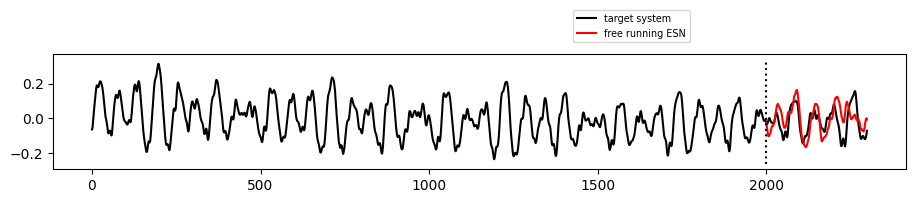

In [37]:
plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+testlen),data[0:trainlen+testlen],'k',label="target system")
plt.plot(range(trainlen,trainlen+testlen),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend(loc=(0.61,1.1),fontsize='x-small')

In [38]:
# For external plotting
np.savetxt("esnsamples.txt", np.column_stack([range(0,trainlen+testlen),data[0:trainlen+testlen]]), fmt="%.4e")
np.savetxt("esn2.txt", np.column_stack([range(trainlen,trainlen+testlen),prediction]), fmt="%.4e")

### Linear predictive coding baseline

In [39]:
from statsmodels.tsa.ar_model import AutoReg

In [41]:
start = 500
trainlen = 2000
testlen = 300
res = AutoReg(data[start:trainlen], 10).fit()
prediction = res.predict(1, testlen)
prediction = np.nan_to_num(prediction, copy=True, nan=0)
print(f"Error: {(np.sqrt(np.mean(np.square(prediction - data[trainlen:trainlen+testlen]))))}")

Error: 0.12705002676764962


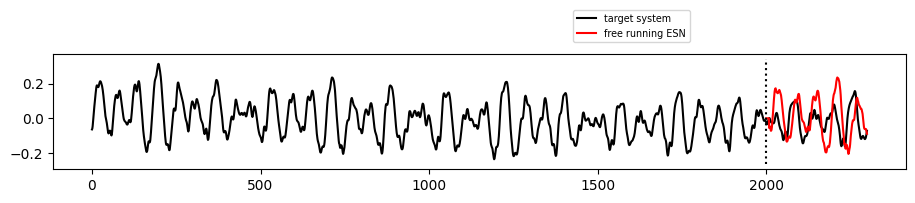

In [42]:
plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+testlen),data[0:trainlen+testlen],'k',label="target system")
plt.plot(range(trainlen,trainlen+testlen),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend(loc=(0.61,1.1),fontsize='x-small')

In [43]:
np.savetxt("arbaseline.txt", np.column_stack([range(trainlen,trainlen+testlen),prediction]), fmt="%.4e")